In [1]:
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback
from stable_baselines3.common.env_checker import check_env
from env5 import Consensus_D_F

# 确保环境符合Gym的规范
env = Consensus_D_F(num_iterations=200, dt=0.1)
check_env(env)

# 创建训练环境实例
train_env = Consensus_D_F()

# 创建评估环境实例
eval_env = Consensus_D_F()

# 定义PPO模型，您可以根据需求调整超参数
model = PPO(
    "MultiInputPolicy",    # 使用多层感知器的策略网络
    train_env,      # 自定义环境
    verbose=1,      # 输出训练信息
    #tensorboard_log="./ppo_consensus_d_f_tensorboard/"  # 日志存储路径（可选）
    tensorboard_log="./ppo_consensus_d_f_tensorboard_new/"  # 日志存储路径（可选）
)

class TriggerCountCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TriggerCountCallback, self).__init__(verbose)
    
    def _on_step(self):
        # 检查是否是 episode 的最后一步
        if self.locals["dones"][0]:  # 当 episode 结束时
            total_trigger_count = self.training_env.get_attr("t")[0]
            
            # 记录到 TensorBoard
            self.logger.record("custom/total_trigger_count", total_trigger_count)
        return True

# 创建评估回调，用于每隔 500000 步进行评估，并将最优模型保存在 `best_model` 文件夹中
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./best_model_single/",
    log_path="./logs/",
    eval_freq=300000,          # 每 500000 步进行一次评估
    n_eval_episodes=5,        # 每次评估进行 20 个 episode
    deterministic=True,
    render=False
)

# 创建自定义的触发计数回调
trigger_count_callback = TriggerCountCallback()

# 开始训练模型，设置训练的时间步数，带有评估回调
#model.learn(total_timesteps=3000000, callback=[trigger_count_callback, eval_callback])
model.learn(total_timesteps=5000000, callback=[trigger_count_callback])

# 保存最终训练好的模型
model.save("ppo_consensus_d_f_single")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_consensus_d_f_tensorboard_new/PPO_5
-------------------------------------
| custom/                |          |
|    total_trigger_count | 99       |
| rollout/               |          |
|    ep_len_mean         | 200      |
|    ep_rew_mean         | -677     |
| time/                  |          |
|    fps                 | 6739     |
|    iterations          | 1        |
|    time_elapsed        | 0        |
|    total_timesteps     | 2048     |
-------------------------------------
---------------------------------------
| custom/                 |           |
|    total_trigger_count  | 118       |
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -453      |
| time/                   |           |
|    fps                  | 4145      |
|    iterations           | 2         |
|    time_elapsed         | 0        

Initial Positions: [-0.3, -0.78, -0.94, 0.64, 0.79]


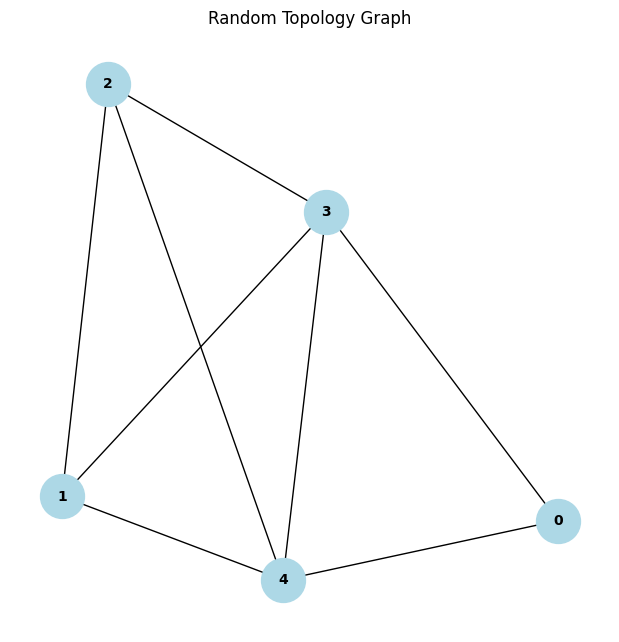

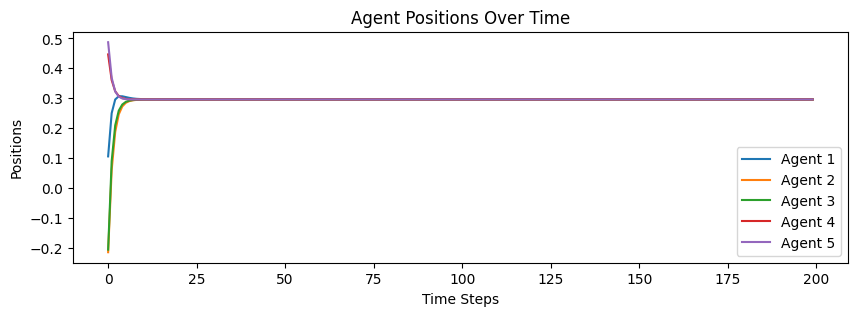

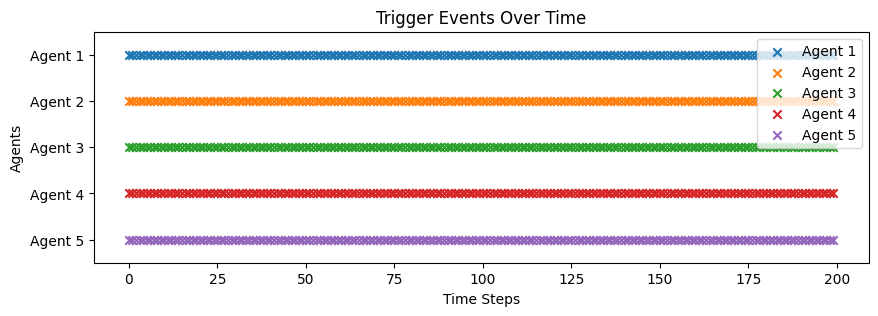

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx  # 用于绘制拓扑结构
from stable_baselines3 import PPO
from env5 import Consensus_D_F  # 引入您的环境

# 仿真函数
def simulate(model_path, env, num_iterations=200, dt=0.1):
    # 加载训练好的模型
    model = PPO.load(model_path)

    # 重置环境并获取初始状态
    env.reset()
    agents = env.agents
    adjacency_matrix = env.neighbor_matrix  # 获取邻接矩阵
    initial_positions = [agent.initial_position for agent in agents]

    # 打印初始位置
    print("Initial Positions:", initial_positions)

    # 绘制拓扑结构图
    plt.figure(figsize=(6, 6))
    G = nx.Graph()
    for i in range(len(adjacency_matrix)):
        for j in range(i + 1, len(adjacency_matrix)):
            if adjacency_matrix[i, j] == 1:  # 检查邻接关系
                G.add_edge(i, j)
    pos = nx.spring_layout(G)  # 使用spring布局
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=10, font_weight='bold')
    plt.title("Random Topology Graph")
    plt.show()

    # 仿真数据记录
    num_agents = len(agents)
    positions_history = np.zeros((num_iterations, num_agents))
    trigger_history = np.zeros((num_iterations, num_agents))

    for t in range(num_iterations):
        for i, agent in enumerate(agents):
            if t == 0:
                # 第一个时间步，所有智能体强制触发
                action = 1
            else:
                # 获取观测
                positions = [agent.position]  # 主智能体位置
                mask = [1]  # 主智能体的观测有效

                for neighbor in agent.neighbors:
                    positions.append(neighbor.position)
                    mask.append(1)

                # 填充到固定长度
                while len(positions) < env.max_neighbors + 1:
                    positions.append(0.0)  # 填充值
                    mask.append(0)  # 无效位置

                # 截断到固定长度
                positions = positions[:env.max_neighbors + 1]
                mask = mask[:env.max_neighbors + 1]

                # 构造观测
                observation = {
                    "positions": np.array(positions, dtype=np.float32),
                    "mask": np.array(mask, dtype=np.float32)
                }

                # 使用模型预测动作
                action, _ = model.predict(observation, deterministic=True)

            # 更新位置
            agent.update_position(t, dt, action)

            # 记录动作触发情况
            trigger_history[t, i] = action


        # 记录每个时间步的所有智能体位置
        positions_history[t, :] = [agent.position for agent in agents]

    # 绘制位置变化
    plt.figure(figsize=(10, 3))
    for i in range(num_agents):
        plt.plot(range(num_iterations), positions_history[:, i], label=f'Agent {i + 1}')
    plt.title("Agent Positions Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Positions")
    plt.legend()
    plt.show()

    # 绘制触发情况
    plt.figure(figsize=(10, 3))
    for i in range(num_agents):
        triggers = np.where(trigger_history[:, i] == 1)[0]
        plt.scatter(triggers, [num_agents - i] * len(triggers), label=f'Agent {i + 1}', marker='x', color=f'C{i}')
    plt.title("Trigger Events Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Agents")
    plt.yticks(range(1, num_agents + 1), [f'Agent {num_agents - i}' for i in range(num_agents)])  # 修改y轴顺序
    plt.ylim(0.5, num_agents + 0.5)  # 调整y轴范围
    plt.legend()
    plt.show()

# 使用您的环境进行仿真
env = Consensus_D_F(num_agents=5, num_iterations=200, dt=0.1)
simulate("/Users/cyj/Documents/Project/Python/Multi-agent-consensus-algorithm/single_agent_algorithm/sb3/ppo_consensus_d_f_single.zip", env)